In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
from tqdm import tqdm


In [3]:
save_path = 'models/model_new.pt'
save_benchmark_path = 'models/model_new_benchmark.pt'
load_path = save_path
load_benchmark_path = save_benchmark_path

TRAIN=False
COMPUTE_INFO=False

In [4]:
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Number of samples in the dataset: 60000


In [5]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution
# Compute the number of classes
num_classes = len(dataset.classes)

num_clients = 5
target_client = 0

# Create subsets
client_distributions =  np.zeros((num_clients, num_classes))
for i in range(num_clients):
    for j in range(5):
        client_distributions[i][j] = 1/6
    client_distributions[i][5+i] = 1/6

client_subsets = split_dataset_by_class_distribution(dataset, client_distributions)


classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1
    
classes_subsets = split_dataset_by_class_distribution(dataset, classes_distributions)


# Create dataloaders
client_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]

benchmark_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]
benchmark_dataloaders.pop(target_client)
target_dataloader = DataLoader(client_subsets[target_client], batch_size=64, shuffle=True)

classes_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=False) for subset in classes_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Total number of samples: 7370


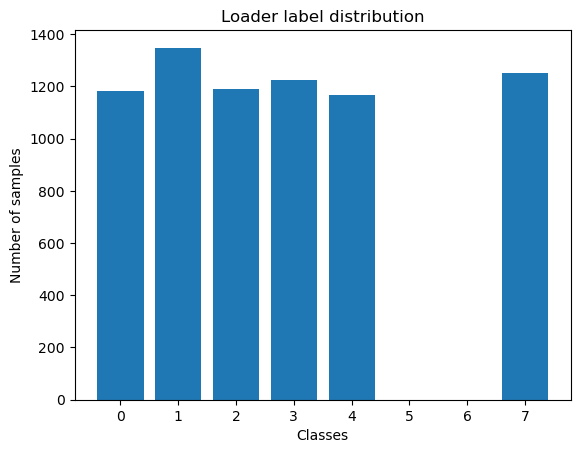

In [6]:
from collections import Counter

def get_label_distribution(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.tolist())
    return dict(label_counts)

# Choose loader to visualize
loader = client_dataloaders[2]

label_distribution = get_label_distribution(loader)
print(f"Total number of samples: {len(loader.dataset)}")
#plot histogram
plt.bar(label_distribution.keys(), label_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title(f'Loader label distribution')
plt.show()


In [7]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [8]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

In [9]:
def trainer(model, loss_fn, client_dataloaders, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for client_loader in client_dataloaders:
            for imgs, labels in client_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                loss = loss_fn(preds, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1
    
    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [10]:
# Model
model = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

if TRAIN:
    model=trainer(model, loss_fn, client_dataloaders, epochs=10)
    save_model_with_unique_name(model, save_path)
    model_benchmark=trainer(model_benchmark, loss_fn, benchmark_dataloaders, epochs=10)
    save_model_with_unique_name(model_benchmark, save_benchmark_path)

else:
    model.load_state_dict(torch.load(load_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(load_benchmark_path, weights_only=True))

In [11]:
if COMPUTE_INFO:
    from fisherunlearn import compute_informations, compute_client_information

    informations = compute_informations(model, loss_fn, client_dataloaders)
    
    with open('cached/informations.pkl', 'wb') as f:
            pickle.dump(informations, f)
else:
    with open('cached/informations.pkl', 'rb') as f:
        informations = pickle.load(f)

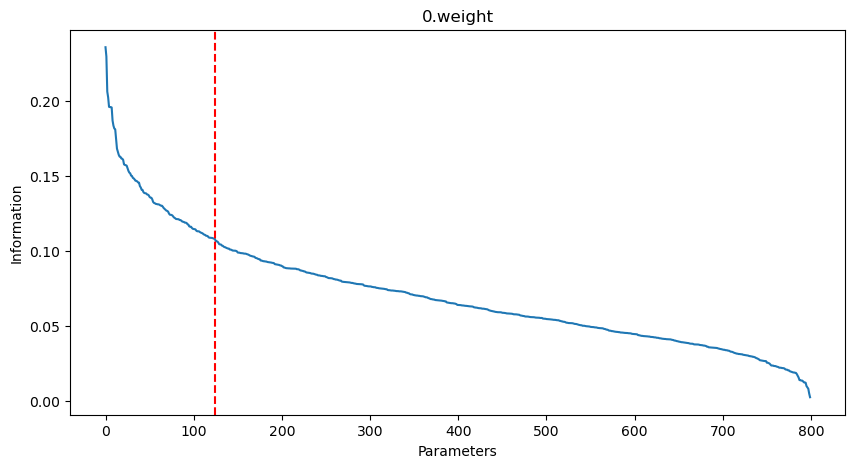

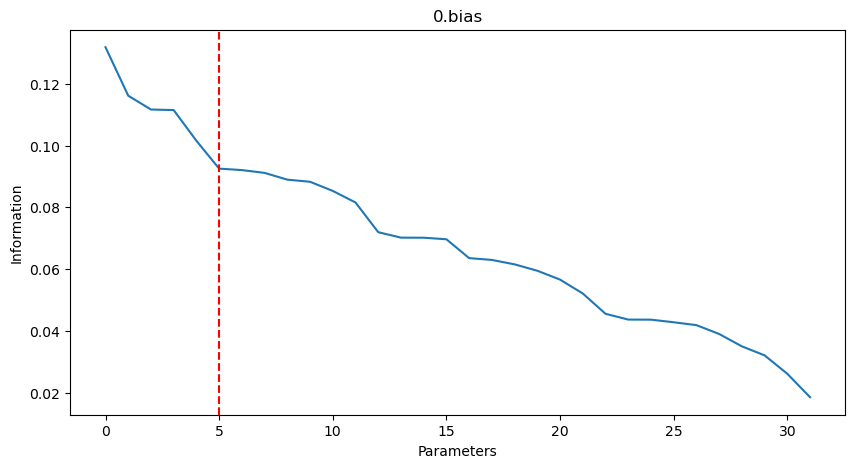

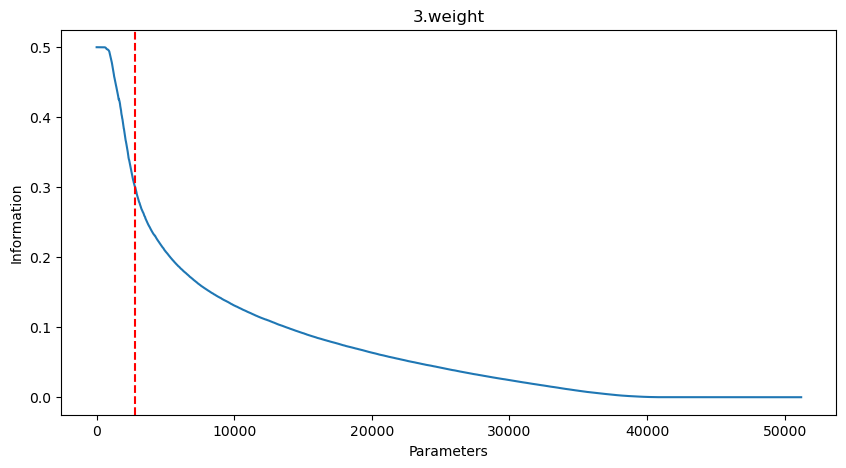

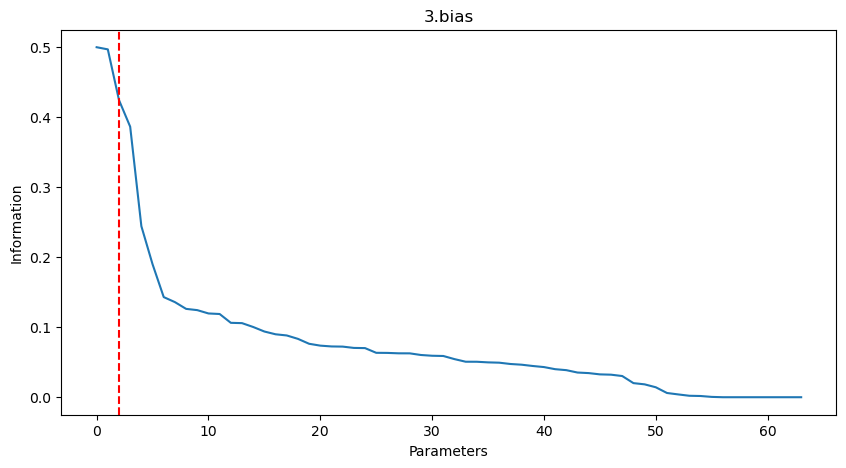

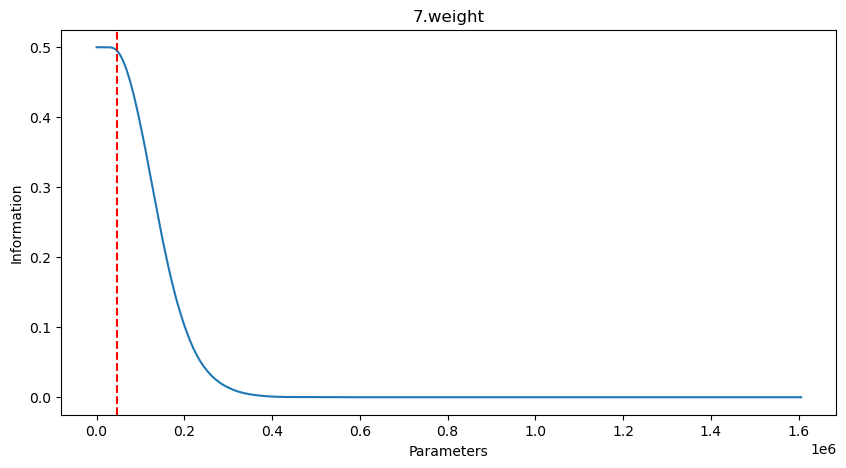

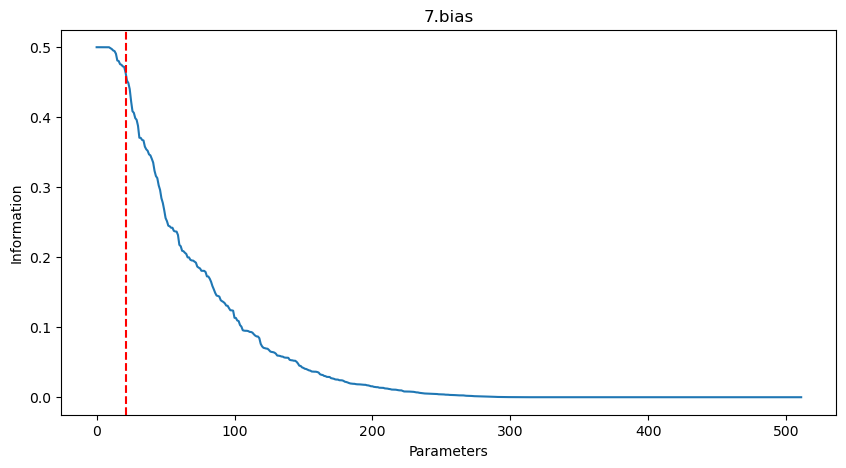

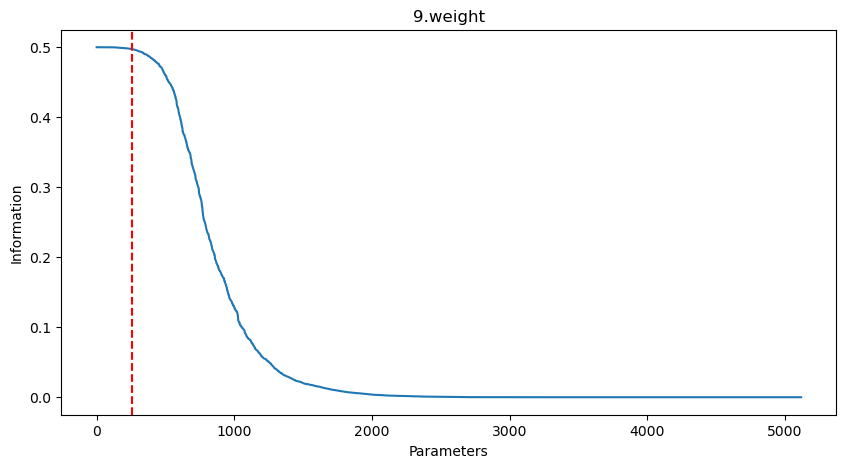

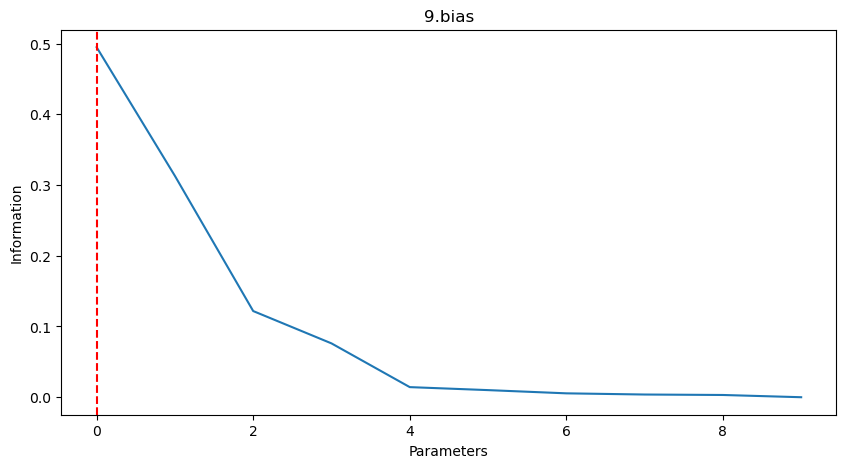

<All keys matched successfully>

In [41]:
from fisherunlearn import find_informative_params, reset_parameters

info=informations[target_client]
#informative_params = find_informative_params(info, method='parameters', percentage=10, graph=False)
informative_params = find_informative_params(info, method='information', percentage=30, graph=True)

resetted_model = FLNet()
resetted_model.load_state_dict(reset_parameters(model, informative_params), strict=False)


In [42]:
from fisherunlearn import UnlearnNet
for name in informative_params.keys():
    print(f"Layer: {name}, number of parameters: {len(informative_params[name])}")
retrainer = UnlearnNet(model, informative_params)
loss_fn = nn.CrossEntropyLoss()
retrainer = trainer(retrainer, loss_fn, benchmark_dataloaders, epochs=1)
retrained_model = FLNet()
retrained_model.load_state_dict(retrainer.get_retrained_params(), strict=False)

Layer: 0.weight, number of parameters: 125
Layer: 0.bias, number of parameters: 6
Layer: 3.weight, number of parameters: 2815
Layer: 3.bias, number of parameters: 3
Layer: 7.weight, number of parameters: 45496
Layer: 7.bias, number of parameters: 22
Layer: 9.weight, number of parameters: 256
Layer: 9.bias, number of parameters: 1
Epoch 1/1, Loss: 0.0037


<All keys matched successfully>

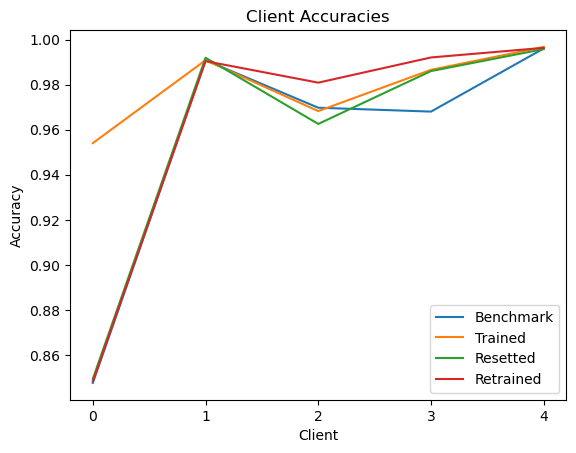

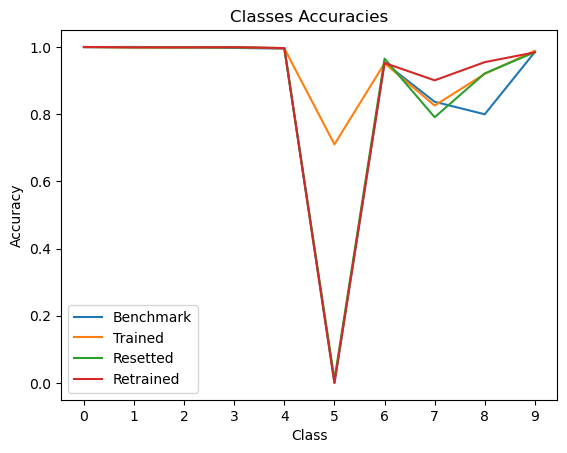

In [43]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, client_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, client_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, client_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, client_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Client')
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Accuracy')
plt.title('Client Accuracies')
plt.show()

plt.plot(compute_dataloaders_accuracy(model_benchmark, classes_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, classes_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, classes_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, classes_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Class')
plt.xticks(np.arange(0, 10, 1))
plt.ylabel('Accuracy')
plt.title('Classes Accuracies')
plt.show()


In [44]:
print("Benchmark model test accuracy:")
print(compute_accuracy(model_benchmark, test_dataloader))
print("Trained model test accuracy:")
print(compute_accuracy(model, test_dataloader))
print("Resetted model test accuracy:")
print(compute_accuracy(resetted_model, test_dataloader))
print("Retrained model test accuracy:")
print(compute_accuracy(retrained_model, test_dataloader))


print("Benchmark model target client accuracy:")
print(compute_accuracy(model_benchmark, target_dataloader))
print("Trained model target client accuracy:")
print(compute_accuracy(model, target_dataloader))
print("Resetted model target client accuracy:")
print(compute_accuracy(resetted_model, target_dataloader))
print("Retrained model target client accuracy:")
print(compute_accuracy(retrained_model, target_dataloader))

Benchmark model test accuracy:
0.8635
Trained model test accuracy:
0.9382
Resetted model test accuracy:
0.8748
Retrained model test accuracy:
0.8877
Benchmark model target client accuracy:
0.8476600472156645
Trained model target client accuracy:
0.9540341619219553
Resetted model target client accuracy:
0.8494653520344396
Retrained model target client accuracy:
0.8483543952228857
